In [137]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from meteostat import Hourly, Point, Stations
import folium
import cdsapi

| Temperature | Impact                                                                                    |
| ----------- | ----------------------------------------------------------------------------------------- |
| **> 35°C**  | **Lethal zone**: Risk of death due to overheating, protein denaturation, oxygen shortage. |
| **30–35°C** | Stressful, reduced activity, possible heat stress.                                        |
| **15–30°C** | ✅ **Optimal range**: Reproduction and composting most active.                             |
| **5–15°C**  | Slower metabolism, but survivable.                                                        |
| **0–5°C**   | Survival possible but with minimal activity. Risk increases with duration.                |
| **< 0°C**   | ❄️ **Danger zone**: Worms usually die unless deeply insulated or burrowed.                |

| Column name | ERA5 variable                       | Description                                                                                 | Units  | Depth (if applicable) |
| ----------- | ----------------------------------- | ------------------------------------------------------------------------------------------- | ------ | --------------------- |
| `t2m`       | `2m_temperature`                    | Air temperature at 2 meters above the surface.                                              | Kelvin | —                     |
| `ssrd`      | `surface_solar_radiation_downwards` | Solar energy reaching the surface per unit area (a measure of sun exposure).                | J/m²   | —                     |
| `stl1`      | `soil_temperature_level_1`          | Soil temperature at layer 1                                                                 | Kelvin | **0–7 cm**            |
| `stl2`      | `soil_temperature_level_2`          | Soil temperature at layer 2                                                                 | Kelvin | **7–28 cm**           |
| `stl3`      | `soil_temperature_level_3`          | Soil temperature at layer 3                                                                 | Kelvin | **28–100 cm**         |
| `soil_type` | `soil_type`                         | Categorical code for soil type (e.g., sand, loam, clay) — not typically used for temp plots | —      | —                     |

In [138]:
import xarray as xr

# Load both datasets
ds_temp = xr.open_dataset("data_stream-oper_stepType-instant.nc")  # temperatures
ds_radiation = xr.open_dataset("data_stream-oper_stepType-accum.nc")  # radiation

# Combine on time axis
ds_combined = xr.merge([ds_temp, ds_radiation])

# Convert to DataFrame
df = ds_combined.to_dataframe().reset_index()

# Convert Kelvin to Celsius
df['temp'] = df['t2m'] - 273.15
df['soil_0_7'] = df['stl1'] - 273.15
df['soil_7_28'] = df['stl2'] - 273.15
df['soil_28_100'] = df['stl3'] - 273.15
# etc.

# Convert J/m² to W/m²
df['sun'] = df['ssrd'] / 3600

In [140]:
df = df.rename(columns={"valid_time": "time"})

In [141]:
def simulate(df, color='black', insulation=False):
    # Constants
    heat_capacity_bin = 1e5 if insulation else 5e4  # in J/°C (adjust to realistic scale)
    emissivity = 0.95
    sigma = 5.67e-8  # Stefan-Boltzmann constant W/m^2/K^4
    absorptivity = 0.9 if color == 'black' else 0.3

    dt = 3600  # 1 hour timestep in seconds

    temperatures = []
    T = df['temp'].iloc[0]  # initial bin temp °C

    for i in range(len(df)):
        ambient = df['temp'].iloc[i]
        sun = df['sun'].iloc[i]  # W/m² solar radiation

        # Convert solar input to energy absorbed during timestep
        # Assume effective surface area = 0.5 m^2 (adjust if you want)
        surface_area = 0.5  # m^2
        solar_energy = absorptivity * sun * surface_area * dt  # Joules absorbed this hour

        # Heat loss by convection (simplified)
        conv_coeff = 5  # W/m²/°C, adjust based on insulation (lower if insulated)
        if insulation:
            conv_coeff = 2

        conv_energy_loss = conv_coeff * surface_area * (T - ambient) * dt  # Joules lost

        # Radiative heat loss
        T_K = T + 273.15
        ambient_K = ambient + 273.15
        rad_energy_loss = emissivity * sigma * surface_area * (T_K**4 - ambient_K**4) * dt  # Joules lost

        # Ventilation (auto-venting lid) increases convective loss if temp > 30°C
        if T > 30:
            vent_coeff = 20  # strong air exchange W/m²/°C
            vent_energy_loss = vent_coeff * surface_area * (T - ambient) * dt
        else:
            vent_energy_loss = 0

        # Net energy change (Joules)
        net_energy = solar_energy - conv_energy_loss - rad_energy_loss - vent_energy_loss

        # Temperature change = energy / heat capacity
        dT = net_energy / heat_capacity_bin
        T += dT
        temperatures.append(T)

    return temperatures


In [142]:
df['month'] = pd.to_datetime(df['time']).dt.month
df_winter = df[df['month'] == 1].copy()
df_summer = df[df['month'] == 7].copy()

df_winter['bin_black_insulated'] = simulate(df_winter, color='black', insulation=True)
df_winter['bin_white_insulated'] = simulate(df_winter, color='white', insulation=True)
df_summer['ambient'] = df_summer['temp']

df_summer['bin_black_insulated'] = simulate(df_summer, color='black', insulation=True)
df_summer['bin_white_insulated'] = simulate(df_summer, color='white', insulation=True)
df_winter['ambient'] = df_winter['temp']

In [143]:
import matplotlib.pyplot as plt


In [145]:
df_summer = df_summer.set_index('time')
df_winter = df_winter.set_index('time')

## Soil and air temperature

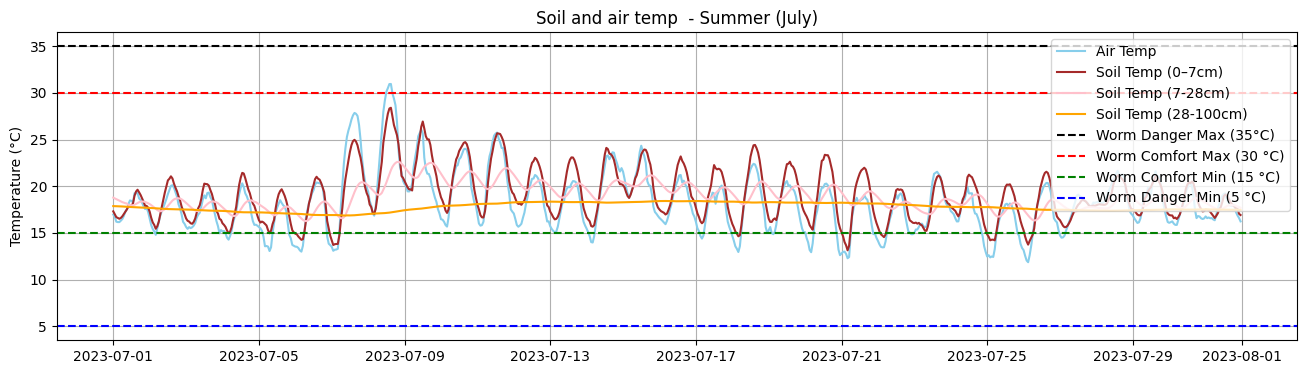

In [146]:
plt.figure(figsize=(16, 4))
plt.plot(df_summer.index, df_summer['ambient'], label='Air Temp', color='skyblue')
plt.plot(df_summer.index, df_summer['soil_0_7'], label='Soil Temp (0–7cm)', color='brown')
plt.plot(df_summer.index, df_summer['soil_7_28'], label='Soil Temp (7-28cm)', color='pink')
plt.plot(df_summer.index, df_summer['soil_28_100'], label='Soil Temp (28-100cm)', color='orange')
plt.title("Soil and air temp  - Summer (July)")
plt.ylabel("Temperature (°C)")
plt.axhline(35, linestyle='--', color='black', label='Worm Danger Max (35°C)')
plt.axhline(30, linestyle='--', color='red', label='Worm Comfort Max (30 °C)')
plt.axhline(15, linestyle='--', color='green', label='Worm Comfort Min (15 °C)')
plt.axhline(5, linestyle='--', color='blue', label='Worm Danger Min (5 °C)')
plt.legend(loc='upper right')
plt.grid()
plt.show()

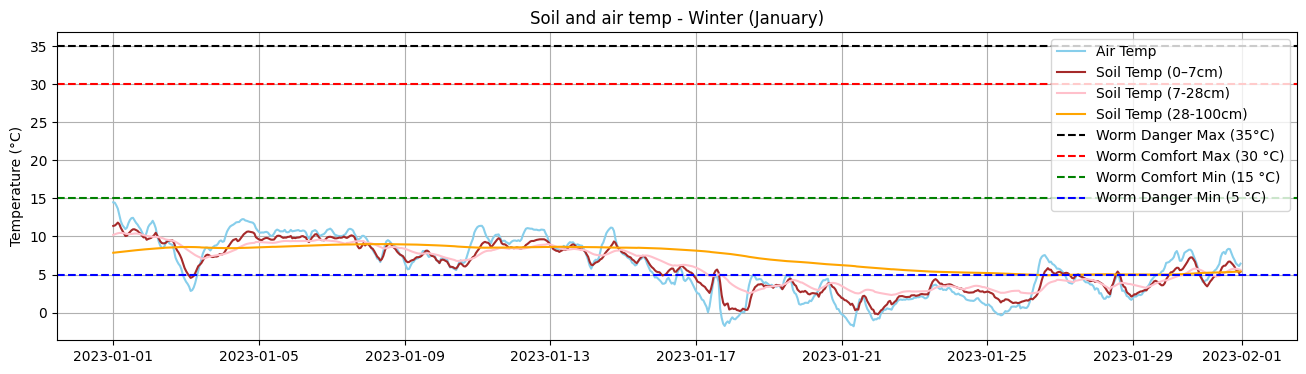

In [147]:
plt.figure(figsize=(16, 4))
plt.plot(df_winter.index, df_winter['ambient'], label='Air Temp', color='skyblue')
plt.plot(df_winter.index, df_winter['soil_0_7'], label='Soil Temp (0–7cm)', color='brown')
plt.plot(df_winter.index, df_winter['soil_7_28'], label='Soil Temp (7-28cm)', color='pink')
plt.plot(df_winter.index, df_winter['soil_28_100'], label='Soil Temp (28-100cm)', color='orange')
plt.title("Soil and air temp - Winter (January)")
plt.ylabel("Temperature (°C)")
plt.axhline(35, linestyle='--', color='black', label='Worm Danger Max (35°C)')
plt.axhline(30, linestyle='--', color='red', label='Worm Comfort Max (30 °C)')
plt.axhline(15, linestyle='--', color='green', label='Worm Comfort Min (15 °C)')
plt.axhline(5, linestyle='--', color='blue', label='Worm Danger Min (5 °C)')
plt.legend(loc='upper right')
plt.grid()
plt.show()

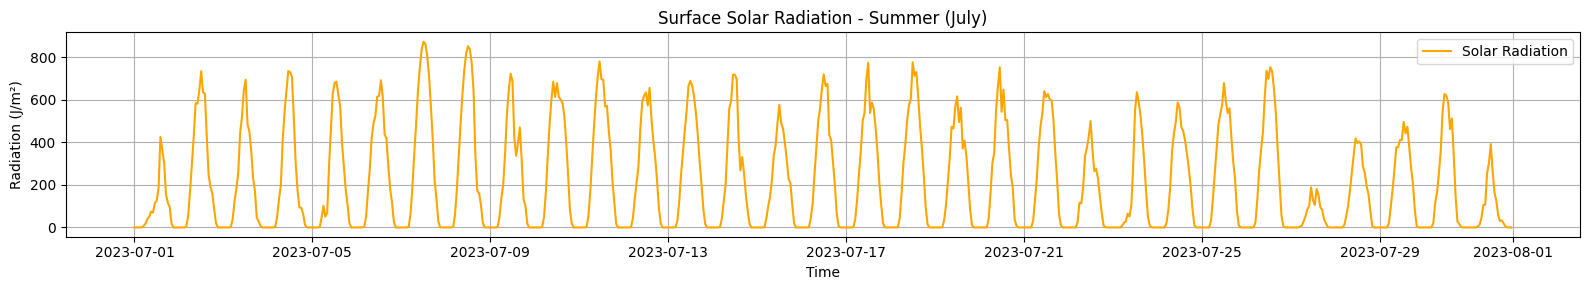

In [194]:
plt.figure(figsize=(16, 3))
plt.plot(df_summer.index, df_summer['sun'], color='orange', label='Solar Radiation')

plt.title("Surface Solar Radiation - Summer (July)")
plt.ylabel("Radiation (J/m²)")
plt.xlabel("Time")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

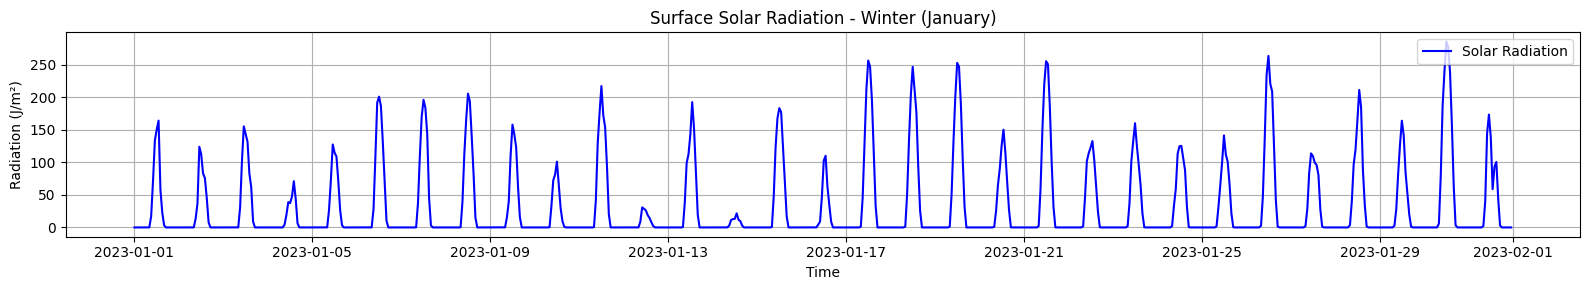

In [166]:
plt.figure(figsize=(16, 3))
plt.plot(df_winter.index, df_winter['sun'], color='blue', label='Solar Radiation')

plt.title("Surface Solar Radiation - Winter (January)")
plt.ylabel("Radiation (J/m²)")
plt.xlabel("Time")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

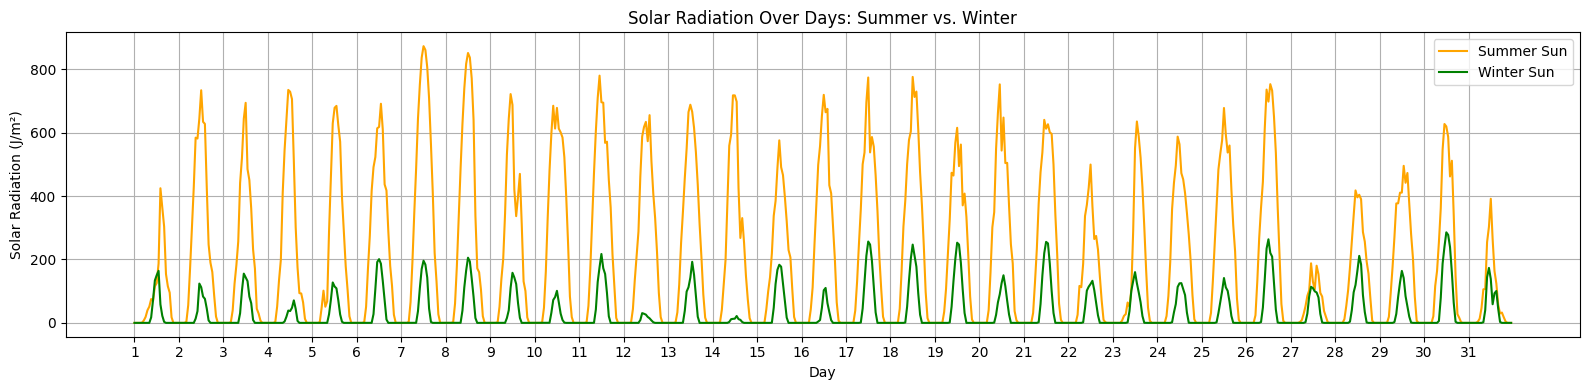

In [224]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate day numbers with fraction of day for x-axis positions
day_summer = (df_summer.index - df_summer.index[0]).days + df_summer.index.hour / 24 + 1
day_winter = (df_winter.index - df_winter.index[0]).days + df_winter.index.hour / 24 + 1

plt.figure(figsize=(16, 4))

plt.plot(day_summer, df_summer['sun'], label='Summer Sun', color='orange')
plt.plot(day_winter, df_winter['sun'], label='Winter Sun', color='green')

plt.title("Solar Radiation Over Days: Summer vs. Winter")
plt.xlabel("Day")
plt.ylabel("Solar Radiation (J/m²)")

# Get unique whole days from summer data to set ticks
unique_days = np.unique(day_summer.astype(int))
plt.xticks(unique_days)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


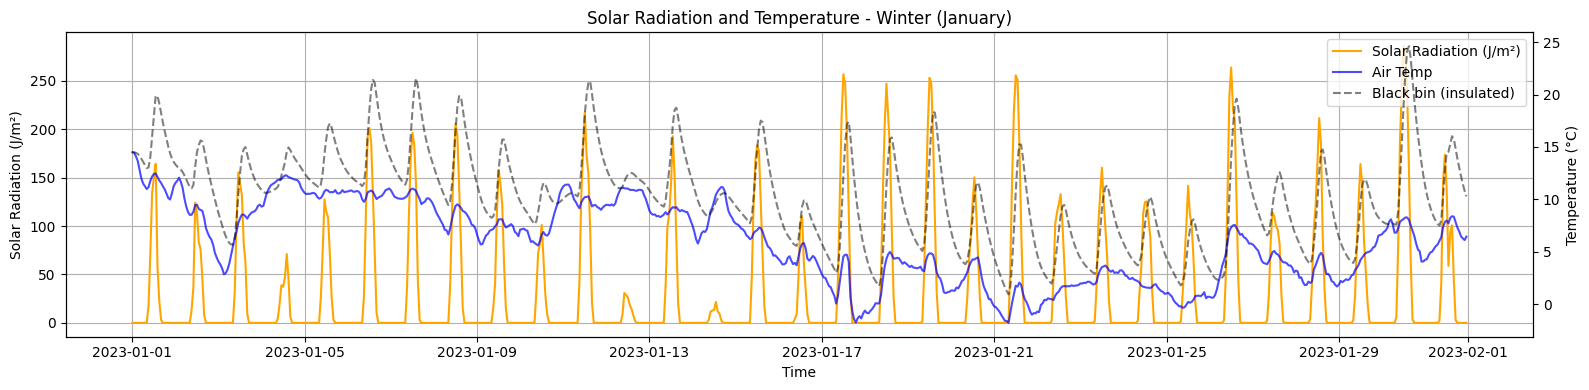

In [216]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot solar radiation on primary y-axis
ax1.plot(df_winter.index, df_winter['sun'], color='orange', label='Solar Radiation (J/m²)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Solar Radiation (J/m²)')
ax1.grid(True)

# Create secondary y-axis for temperatures
ax2 = ax1.twinx()
ax2.plot(df_winter.index, df_winter['temp'], color='blue', label='Air Temp', alpha=0.7)
ax2.plot(df_winter.index,  df_winter['bin_black_insulated'], linestyle='--', label='Black bin (insulated)', color='black', alpha=0.5)
ax2.set_ylabel('Temperature (°C)')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Solar Radiation and Temperature - Winter (January)")
plt.tight_layout()
plt.show()


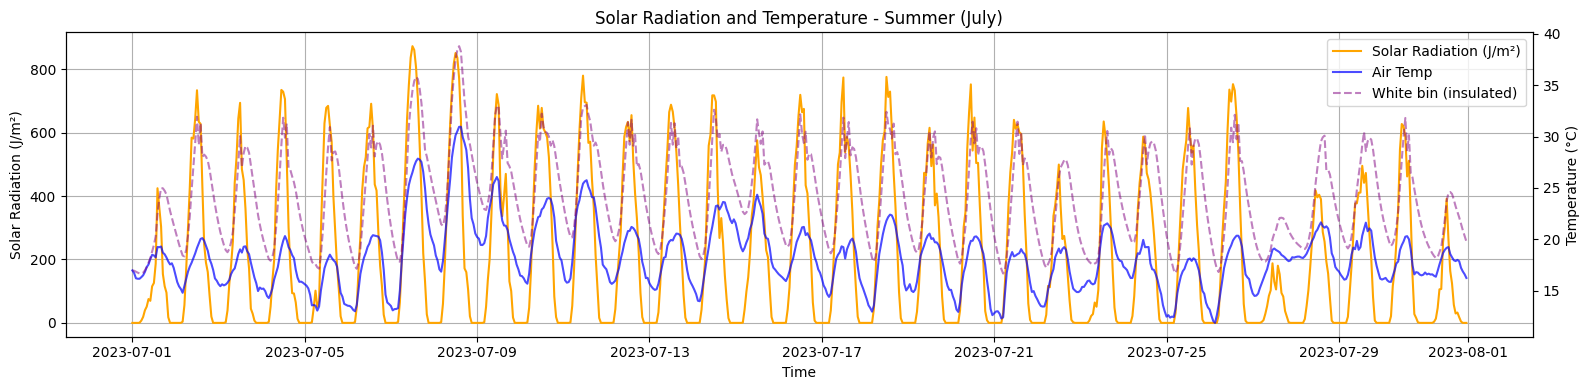

In [214]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot solar radiation on primary y-axis
ax1.plot(df_summer.index, df_summer['sun'], color='orange', label='Solar Radiation (J/m²)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Solar Radiation (J/m²)')
ax1.grid(True)

# Create secondary y-axis for temperatures
ax2 = ax1.twinx()
ax2.plot(df_summer.index, df_summer['temp'], color='blue', label='Air Temp', alpha=0.7)
ax2.plot(df_summer.index,  df_summer['bin_white_insulated'], linestyle='--', label='White bin (insulated)', color='purple', alpha=0.5)
ax2.set_ylabel('Temperature (°C)')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')


plt.title("Solar Radiation and Temperature - Summer (July)")
plt.tight_layout()
plt.show()

# Compare bin setups

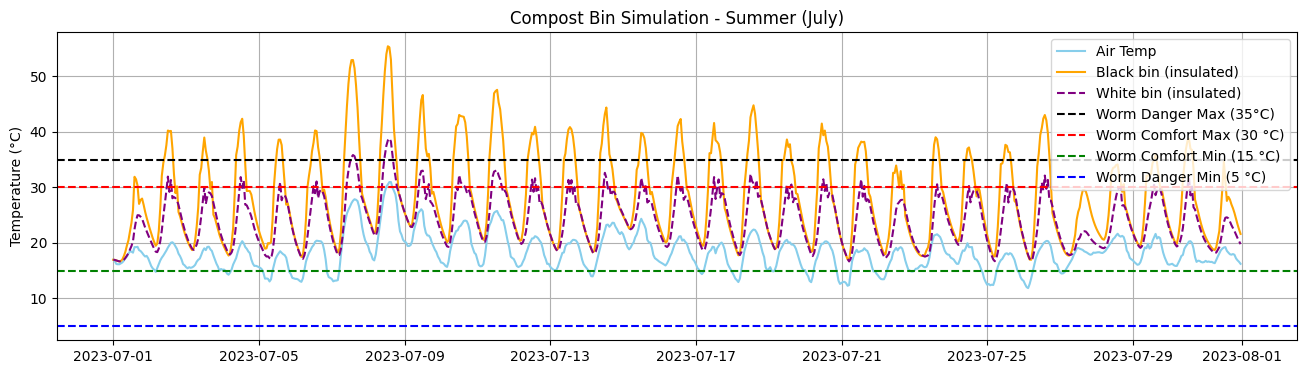

In [203]:
plt.figure(figsize=(16, 4))
plt.plot(df_summer.index, df_summer['ambient'], label='Air Temp', color='skyblue')
plt.plot(df_summer.index, df_summer['bin_black_insulated'], label='Black bin (insulated)', color='orange')
plt.plot(df_summer.index, df_summer['bin_white_insulated'], label='White bin (insulated)', color='purple', linestyle='--')
plt.title("Compost Bin Simulation - Summer (July)")
plt.ylabel("Temperature (°C)")
plt.axhline(35, linestyle='--', color='black', label='Worm Danger Max (35°C)')
plt.axhline(30, linestyle='--', color='red', label='Worm Comfort Max (30 °C)')
plt.axhline(15, linestyle='--', color='green', label='Worm Comfort Min (15 °C)')
plt.axhline(5, linestyle='--', color='blue', label='Worm Danger Min (5 °C)')
plt.legend()
plt.grid()
plt.show()

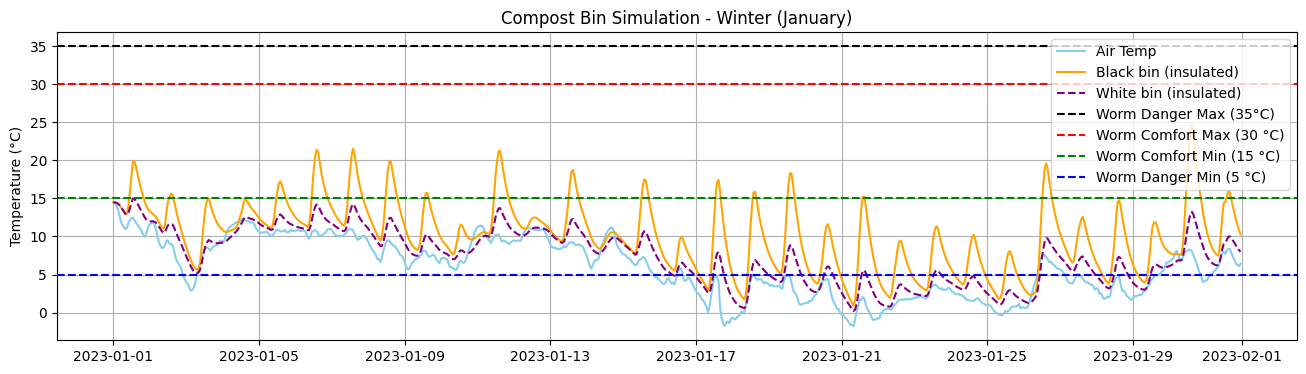

In [189]:
plt.figure(figsize=(16, 4))
plt.plot(df_winter.index, df_winter['ambient'], label='Air Temp', color='skyblue')
plt.plot(df_winter.index, df_winter['bin_black_insulated'], label='Black bin (insulated)', color='orange')
plt.plot(df_winter.index, df_winter['bin_white_insulated'], label='White bin (insulated)', color='purple', linestyle='--')
plt.title("Compost Bin Simulation - Winter (January)")
plt.ylabel("Temperature (°C)")
plt.axhline(35, linestyle='--', color='black', label='Worm Danger Max (35°C)')
plt.axhline(30, linestyle='--', color='red', label='Worm Comfort Max (30 °C)')
plt.axhline(15, linestyle='--', color='green', label='Worm Comfort Min (15 °C)')
plt.axhline(5, linestyle='--', color='blue', label='Worm Danger Min (5 °C)')
plt.legend()
plt.grid()
plt.show()